# Topic Modelling

As the second part of the intial assessment of the capstone 2, I will do some topic modelling to the articles dataset, and perhaps the wikipedia documents. The idea is not only find similarities between the two corpii in content but also in time, and see what topics attract the most interest from wikipedia users.

The intial dataset I will try this on is from https://www.kaggle.com/snapcrack/all-the-news/version/4, and I will use sklearn to use NMF and LDA (I think) to quantify topics. I also want to find similarities between different articles, especially between these and the wikipedia ones. Let's see how we do that...

In [1]:
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups


In [2]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

We need to use our own dataset instead of that predefined...

In [3]:
import pandas as pd

df1 = pd.read_csv('articles/articles1.csv')

In [4]:
df1.head()

Improvements:

* Drop: unnamed, id, author, url, month and year
* Parse dates

Load the other 3 files and merge/concatenate them resetting indices

In [5]:
df1 = df1[['title', 'publication', 'date', 'content']]
df1['date']=pd.to_datetime(df1['date'])
df1.head()

In [6]:
df2 = pd.read_csv('articles/articles2.csv')
df2 = df2[['title', 'publication', 'date', 'content']]
df2['date']=pd.to_datetime(df1['date'])

df3 = pd.read_csv('articles/articles3.csv')
df3 = df3[['title', 'publication', 'date', 'content']]
df3['date']=pd.to_datetime(df1['date'])

In [7]:
df3.head()

In [8]:
allarts = pd.concat([df1,df2,df3],ignore_index=True)

In [9]:
allarts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142570 entries, 0 to 142569
Data columns (total 4 columns):
title          142568 non-null object
publication    142570 non-null object
date           142570 non-null datetime64[ns]
content        142570 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 4.4+ MB


In [10]:
allarts.head()

In [11]:
allarts.describe()

In [12]:
allarts.groupby('publication').count()

The adverts need to go. In adidition, we won't be using Breitbart news after the lawsuit by difamation and spreading false information. Interstingly, all adverts are from Breitbart anyway, so we can hit two birds with one stone

In [13]:
allarts[allarts['content']=='advertisement']

In [14]:
allarts = allarts[allarts['publication']!='Breitbart']

In [15]:
# let's look at the dates
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
allarts.groupby('publication').count()

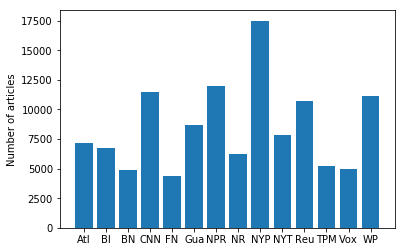

In [17]:
import numpy as np

ticklabels=[]
for paper in (allarts.groupby('publication').count().index):
    paperwords = paper.split(' ')
    if len(paperwords) > 1:
        # use intials to identify the paper
        pprinit = ''
        for word in paperwords:
            pprinit += word[0]
        ticklabels.append(pprinit)
    else:
        # use only first 3 words
        ticklabels.append(paperwords[0][0:3])
    
plt.bar(np.arange(len(allarts.groupby('publication').count().index)), allarts.groupby('publication').count()['title'].tolist(), 
        tick_label = ticklabels)
plt.ylabel('Number of articles')
plt.show()

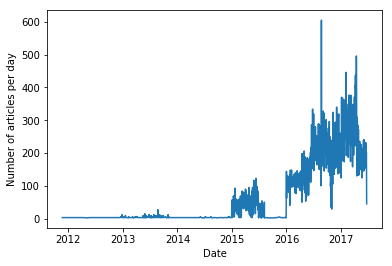

In [18]:
sns.lineplot(data=allarts.groupby('date').count()['title'])
plt.ylabel('Number of articles per day')
plt.xlabel('Date')
plt.show()

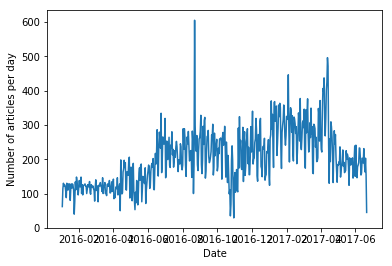

In [19]:
allarts = allarts[allarts['date']>'20160101']

sns.lineplot(data=allarts.groupby('date').count()['title'])
plt.ylabel('Number of articles per day')
plt.xlabel('Date')
plt.show()

So I will use all the articles from 2016 and later to train the topic modeller, which are the ones needed to compare to the wikipedia dataset. Form the description before we know the last one is on June 21st, 2017.

Adpated from http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [20]:
allarts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108298 entries, 0 to 140124
Data columns (total 4 columns):
title          108296 non-null object
publication    108298 non-null object
date           108298 non-null datetime64[ns]
content        108298 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 4.1+ MB


In [21]:
n_samples = 1500
n_features = 100
n_components = 10 # tis the number of topics
n_top_words = 10

data_samples = allarts['content'].tolist()[:n_samples]

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

# Fit the NMF model
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Extracting tf-idf features for NMF...
done in 1.430s.
Extracting tf features for LDA...
done in 1.401s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=1500 and n_features=100...
done in 1.717s.

Topics in NMF model (Frobenius norm):
Topic #0: mr said wrote political case years called court president later
Topic #1: like just time people way women life years work don
Topic #2: ms said family women school children life later time told
Topic #3: trump president mr white house administration obama news campaign said
Topic #4: united states american order government russia officials administration country security
Topic #5: health care republicans law republican house obama federal court people
Topic #6: company million percent year chief executive said 000 years like
Topic #7: new times york city news year public state week day
Topic #8: said police people city state officials 000 government added team
Topic #9: china north government world said year officials coun

It seems that LDA is qualitatively better because the topics are more diverse and comprehensible.

Now, we need to do two things: compare the performance, and compare how close different articles are form each other. With that I will choose an algorithm and ba able to correlate information between different sources.

The performance can be calculated using topic coherence, perplexity or log likelihood. The first is the most used because it brings about a more qualitative decription of the topics, while the others are not straightforward to understand.

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
import numpy as np

coheach = []
for topic_idx, topic in enumerate(lda.components_):
    topwordlist = topic.argsort()[:-n_top_words - 1:-1]
    listofpariwisesims = []
    for pair in combinations(topwordlist, 2):
        listofpariwisesims.append(cosine_similarity(tf[:,pair[0]].T,tf[:,pair[1]].T)[0][0])
    coheach.append(np.mean(listofpariwisesims))
    
print('LDA coherence', np.mean(coheach))


coheach = []
for topic_idx, topic in enumerate(nmf.components_):
    topwordlist = topic.argsort()[:-n_top_words - 1:-1]
    listofpariwisesims = []
    for pair in combinations(topwordlist, 2):
        listofpariwisesims.append(cosine_similarity(tfidf[:,pair[0]].T,tfidf[:,pair[1]].T)[0][0])
    coheach.append(np.mean(listofpariwisesims))
    
print('NMF-KL coherence', np.mean(coheach))

LDA coherence 0.40650791316441925
NMF-KL coherence 0.2937728953405744


And finding the dominant topics for each doc may come later from here...
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#13compareldamodelperformancescores

For now, let's just use the topic of a current document...

In [22]:
doc_topic = lda.transform(tf[37])
print('Topic: ',doc_topic.argmax())

#doc_topic = lda.transform(tf)
#for n in range(doc_topic.shape[0]):
#    topic_most_pr = doc_topic[n].argmax()
#    print("doc: {} topic: {}\n".format(n,topic_most_pr))

Topic:  6


And I also want the cosine similarity between any two documents, but that's as easy as calling the function to tf[0], tf[1] for instance